In [23]:
import spacy
from typing import Tuple, Dict
from collections import defaultdict
import pandas as pd
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
nlp = spacy.load('en_core_web_md')

PATH_TO_FOUR_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                            'NRC-Affect-Intensity-Lexicon/NRC-AffectIntensity-Lexicon.csv'

PATH_TO_EIGHT_CLASSES_DATA = './NRC-Sentiment-Emotion-Lexicons/' \
                             'NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.csv'

POS_MULTIPLIER = {'ADJ': 0.9, 'ADV': 0.8, 'VERB': 0.75, 'NOUN': 0.7}

# reading first dataset
four_classes = pd.read_csv(PATH_TO_FOUR_CLASSES_DATA, names=['token', 'score', 'label'], sep=r"\s+")
# reading second dataset
eight_classes = pd.read_csv(PATH_TO_EIGHT_CLASSES_DATA, names=['token', 'label', 'score'], sep=r"\s+")

In [3]:
# clean text
def clean_text(text: str) -> str:
    doc = nlp(text)
    # removing stop words and punctuation
    tokens = ' '.join(
        [re.sub('\n', '', token.text.lower()) for token in doc if not token.is_stop and not token.is_punct])
    return tokens

In [4]:
# normalization of each result
def scale_dict_result(dict_):
    values = dict_.values()
    min_ = min(values)
    max_ = max(values)
    return {key: ((v - min_) / (max_ - min_)) for (key, v) in dict_.items()}

In [5]:
def eval_text(text: str, dataset: pd.DataFrame, multiply: bool) -> Tuple:
    doc = nlp(text)
    emotional_class = defaultdict(list)
    result_dict = {}
    for token in doc:
        multiplier = 1
        if multiply:
            # part of speech
            pos = token.pos_
            try:
                multiplier = POS_MULTIPLIER[pos]
            except KeyError:
                continue
        sub_df = dataset.loc[dataset.token == token.text]
        if not sub_df.empty:
            for index, row in sub_df.iterrows():
                tmp = [row['token'], float(row['score'])*multiplier]
                if tmp not in emotional_class[row['label']]:
                    emotional_class[row['label']].append(tmp)
    if 'positive' in emotional_class:
        emotional_class.pop('positive')
        emotional_class.pop('negative')
    # probabilities calc
    s = 0
    for k, _ in emotional_class.items():
        result_dict[k] = sum(map(lambda x: x[1], emotional_class[k]))
        s += result_dict[k]
    for k, v in result_dict.items():
        result_dict[k] = v / s
    return emotional_class, result_dict


In [6]:
# load text
filename = 'testText.txt'
file = open(filename, 'rt')
text = file.read()
file.close()


In [7]:
text = clean_text(text)
result1 = eval_text(text, four_classes, multiply=False)[1]
result2 = eval_text(text, eight_classes, multiply=True)[1]

# taking max values from each dataset, result2 is wider
aggregated_result = result2.copy()
for k, v in aggregated_result.items():
    if k in result1:
        aggregated_result[k] = max(result1[k], aggregated_result[k])

# labeling via min between emotional classes
labels = dict()
labels['high_positive'] = max([min(aggregated_result['joy'], aggregated_result['surprise']),
                               min(aggregated_result['joy'], aggregated_result['trust'])])
labels['positive'] = max([min(aggregated_result['joy'], aggregated_result['anticipation'])])
labels['neutral'] = max([min(aggregated_result['trust'], aggregated_result['anticipation']),
                         min(aggregated_result['surprise'], aggregated_result['anticipation'])])
labels['negative'] = max([min(aggregated_result['sadness'], aggregated_result['fear']),
                          min(aggregated_result['fear'], aggregated_result['anticipation'])])
labels['high_negative'] = max([min(aggregated_result['anger'], aggregated_result['disgust']),
                               min(aggregated_result['anger'], aggregated_result['fear']),
                               min(aggregated_result['disgust'], aggregated_result['fear'])])

In [8]:
display(labels)

{'high_negative': 0.2018140589569161,
 'high_positive': 0.06802721088435373,
 'negative': 0.23356009070294786,
 'neutral': 0.06802721088435373,
 'positive': 0.10204081632653061}

In [9]:
from skfuzzy import trimf
x = np.linspace(start = -1, stop = 1, num = 50)

In [10]:
m_functions = {}
m_functions['high_negative'] = trimf(x, [-1, -1, -.5]) # high negative mem. function
m_functions['negative'] = trimf(x, [-1, -0.5, 0]) # negative mem. function
m_functions['neutral'] = trimf(x, [-.5, 0, .5]) # neutral mem. function
m_functions['positive'] = trimf(x, [0, .5, 1]) # positive mem. function
m_functions['high_positive'] = trimf(x, [.5, 1, 1]) # high positive mem. function

In [11]:
mu_ = [m_functions[k] for k,_ in labels.items()]
mu_i = [labels[k] * m_functions[k] for k,_ in labels.items()]
mu_s = np.max(mu_i, axis=0)
display(mu_s)

array([0.20181406, 0.18533944, 0.16886482, 0.15239021, 0.13591559,
       0.11944097, 0.11439678, 0.13346291, 0.15252904, 0.17159517,
       0.1906613 , 0.20972743, 0.22879356, 0.21926049, 0.20019436,
       0.18112823, 0.1620621 , 0.14299597, 0.12392984, 0.10486371,
       0.08579758, 0.06673145, 0.05414411, 0.05969735, 0.06525059,
       0.06525059, 0.05969735, 0.05414411, 0.04859086, 0.04303762,
       0.04581424, 0.05414411, 0.06247397, 0.07080383, 0.07913369,
       0.08746356, 0.09579342, 0.09995835, 0.09162849, 0.08329863,
       0.07496876, 0.0666389 , 0.05830904, 0.04997918, 0.04164931,
       0.04581424, 0.05136749, 0.05692073, 0.06247397, 0.06802721])

In [12]:
display(mu_i)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00138831, 0.00694155, 0.01249479,
        0.01804804, 0.02360128, 0.02915452, 0.03470776, 0.040261  ,
        0.04581424, 0.05136749, 0.05692073, 0.06247397, 0.06802721]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [13]:
# mass center calculation
y = np.trapz(x * mu_s, x=x) / np.trapz(mu_s, x=x)
display(y)

-0.2294926323735252

In [39]:
label = list(labels.keys())
label.reverse()
display(label)

['high_negative', 'negative', 'neutral', 'positive', 'high_positive']

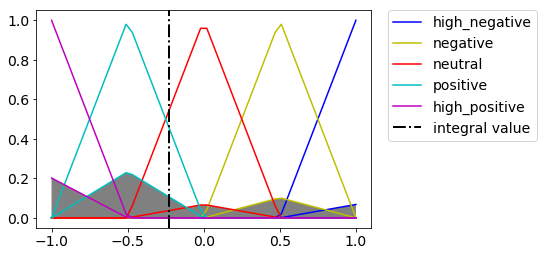

In [50]:
# ploting results
k = 0
colors = ['b', 'y', 'r', 'c', 'm']
for item in zip(mu_, mu_i):
    plt.plot(x, item[0], label=label[k], color=colors[k])
    plt.plot(x, item[1], color=colors[k])
    plt.fill_between(x, 0, item[1], facecolor='grey')
    k += 1
plt.axvline(x=y, ymin=0, ymax=1, color='black', linewidth=2, label='integral value', linestyle='-.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)